In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import datetime

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [2]:
#python package version information
print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('MatlpotLib version:{}'.format(matplotlib.__version__))
print('Seaborn version:{}'.format(sns.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__))
print('XGBoost version:{}'.format(xgboost.__version__))

Python version:3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Numpy version:1.23.3
Pandas version:1.4.4
MatlpotLib version:3.5.2
Seaborn version:0.12.1
Sci-Kit Learn version:1.1.3
XGBoost version:1.7.1


In [3]:
eu = yf.download('EURUSD=X', start='2003-12-01', end='2018-01-01')
eu.columns = map(str.lower, eu.columns)
eu = eu.drop('volume', axis=1)
eu = eu.drop('adj close', axis=1)

end_train = datetime.datetime(2018, 1, 1, 0, 0)
eu = eu.loc[:end_train]
eu.describe()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close
count,3647.000000,3647.000000,3647.000000,3647.000000
mean,1.283771,1.288921,1.278075,1.283794
std,0.118784,0.119258,0.120109,0.118775
min,1.039393,1.041992,0.072902,1.039047
25%,1.202950,1.208196,1.198444,1.202856
50%,1.292491,1.297820,1.287498,1.292892
75%,1.360646,1.365012,1.355721,1.360479
max,1.598184,1.602821,1.587402,1.598798


In [4]:
eu

,open,high,low,close
Date,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501
2003-12-02,1.196101,1.210903,1.194600,1.208897
2003-12-03,1.209000,1.213003,1.207700,1.212298
2003-12-04,1.212004,1.214403,1.204398,1.208094
2003-12-05,1.207802,1.219096,1.206593,1.218695
...,...,...,...,...
2017-12-25,1.185677,1.188495,1.184904,1.185607
2017-12-26,1.187127,1.187790,1.184750,1.187254
2017-12-27,1.186099,1.191043,1.185565,1.185789


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


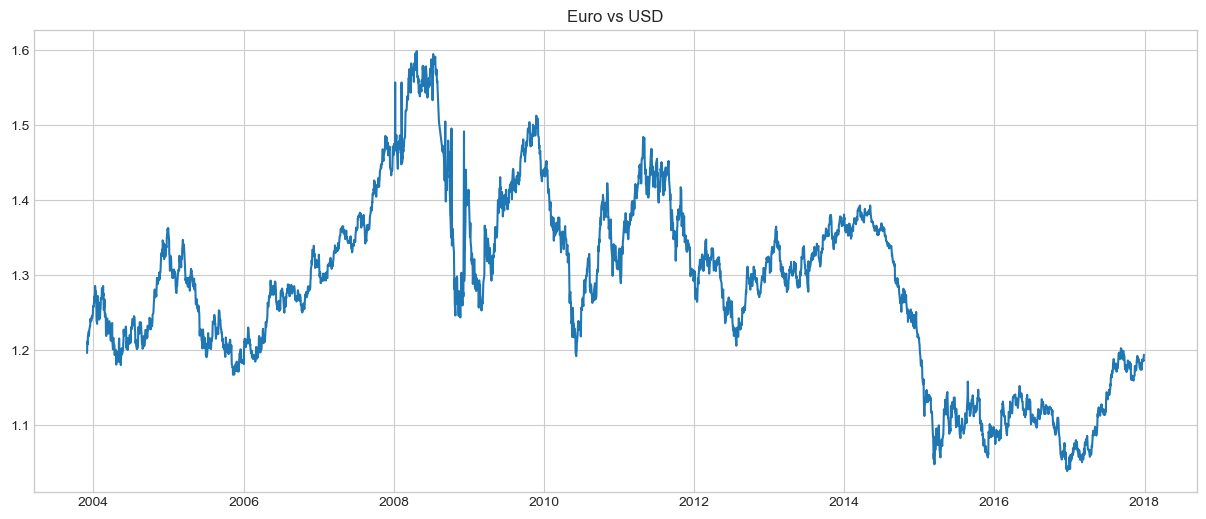

In [5]:
plt.figure(figsize=(15,6))
plt.plot(eu.close)
plt.title('Euro vs USD')
plt.legend()
plt.show()

In [6]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
                                       
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(eu)

In [7]:
data

,open,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,...,ratio_std_price_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
Date,,,,,,,,,,,,,,,,,,,,,
2004-11-19,1.294800,1.303798,1.294901,1.307292,1.294398,1.297178,1.283604,1.244797,1.232100,1.010574,...,1.114490,-0.006824,0.003017,0.034354,0.050890,0.082239,0.000614,0.000802,0.000337,1.303900
2004-11-22,1.302592,1.294800,1.303900,1.306404,1.294197,1.298558,1.285795,1.246205,1.232477,1.009926,...,1.124761,0.006950,0.005320,0.036574,0.072992,0.078586,0.001075,0.001131,0.000323,1.304002
2004-11-23,1.304206,1.302592,1.304002,1.305193,1.301693,1.300559,1.287795,1.247726,1.232840,1.009911,...,1.127413,0.000078,0.007733,0.033278,0.079296,0.075645,0.001554,0.001224,0.000312,1.309706
2004-11-24,1.309998,1.304206,1.309706,1.310307,1.297993,1.303261,1.289729,1.249331,1.233244,1.010493,...,1.131856,0.004374,0.010425,0.031996,0.083651,0.084109,0.002089,0.001288,0.000343,1.317801
2004-11-25,1.318096,1.309998,1.317801,1.319105,1.308695,1.306062,1.291476,1.251043,1.233637,1.011294,...,1.138419,0.006180,0.010740,0.028649,0.089176,0.081321,0.002152,0.001369,0.000333,1.325803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25,1.185677,1.185157,1.185733,1.186197,1.181754,1.182093,1.182982,1.176668,1.128459,0.999248,...,0.163710,-0.001755,0.006996,0.003605,-0.005858,0.126375,0.001400,-0.000084,0.000483,1.185607
2017-12-26,1.187127,1.185677,1.185607,1.188495,1.184904,1.184343,1.182992,1.176669,1.129013,1.001142,...,0.164180,-0.000107,0.009580,0.000178,0.000035,0.133464,0.001912,0.000009,0.000508,1.187254
2017-12-27,1.186099,1.187127,1.187254,1.187790,1.184750,1.186109,1.182735,1.176806,1.129589,1.002852,...,0.166757,0.001389,0.007492,-0.004523,0.007337,0.139407,0.001497,0.000124,0.000528,1.185789


In [8]:
data.describe()

,open,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,...,ratio_std_price_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,...,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000
mean,1.287657,1.287690,1.287688,1.292793,1.281992,1.287753,1.288000,1.288427,1.290441,0.999828,...,0.512326,0.000006,-0.000026,-0.000074,0.000205,-0.002143,0.000007,0.000017,0.000008,1.287658
std,0.122020,0.122009,0.122009,0.122525,0.123401,0.121688,0.120854,0.118568,0.106574,0.012537,...,0.224854,0.008153,0.014433,0.028977,0.048845,0.091199,0.002901,0.000781,0.000362,0.122019
min,1.039393,1.039393,1.039047,1.041992,0.072902,1.041875,1.048554,1.059122,1.088972,0.945349,...,0.162754,-0.133526,-0.101166,-0.151236,-0.206367,-0.239474,-0.020386,-0.003400,-0.001072,1.039047
25%,1.197103,1.197117,1.197418,1.202993,1.193602,1.198484,1.201900,1.204649,1.231661,0.992483,...,0.341054,-0.003508,-0.007943,-0.016378,-0.028227,-0.073155,-0.001580,-0.000431,-0.000256,1.197404
50%,1.301397,1.301406,1.301329,1.306259,1.295706,1.301802,1.302310,1.307144,1.307552,1.000370,...,0.461483,0.000000,0.000163,0.000633,0.005219,0.006644,0.000054,0.000112,0.000054,1.301329
75%,1.363666,1.363666,1.363768,1.368701,1.359193,1.363423,1.362903,1.361323,1.364553,1.007935,...,0.653000,0.003535,0.008473,0.017941,0.032876,0.064261,0.001705,0.000544,0.000265,1.363768
max,1.598184,1.598184,1.598798,1.602821,1.587402,1.589879,1.578920,1.565087,1.500027,1.061568,...,1.345655,0.173079,0.184059,0.173348,0.140425,0.217656,0.036492,0.002129,0.000876,1.598798


<AxesSubplot:xlabel='Date'>

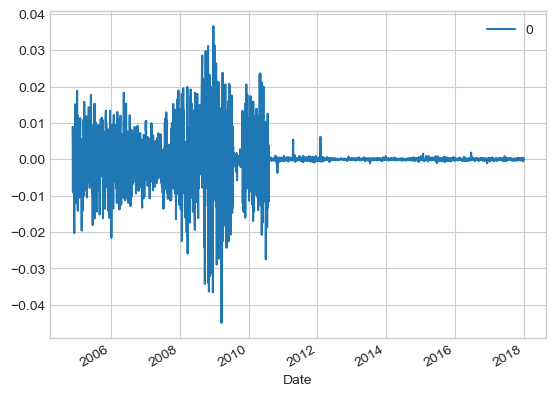

In [22]:
pd.DataFrame(data.open_1 - data.close_1).plot()

<AxesSubplot:xlabel='Date'>

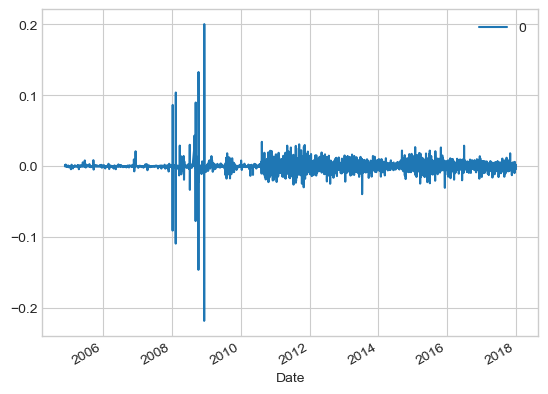

In [23]:
pd.DataFrame(data.close_1.shift() - data.open_1).plot()

<AxesSubplot:>

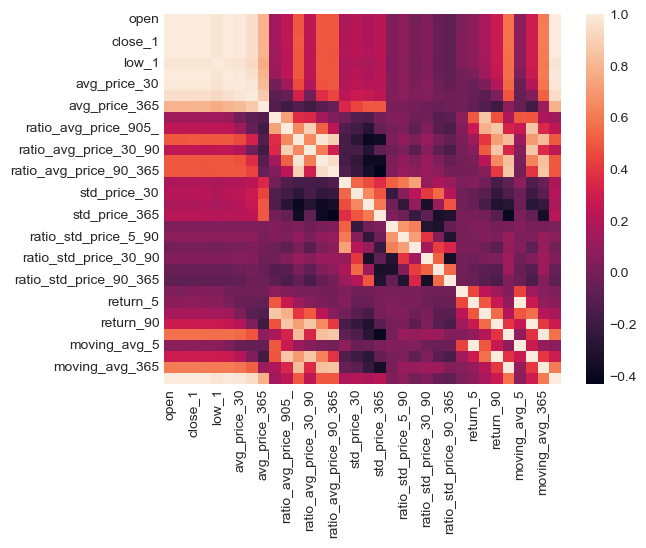

In [9]:
sns.heatmap(data.corr())

### SEGREGATING TRAIN AND TEST DATA

In [10]:
#import datetime module
import datetime

#segregate data for training
start_train = datetime.datetime(1999, 1, 1,0,0)
end_train = datetime.datetime(2019, 6, 7, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()

,open,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,...,ratio_std_price_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,...,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000
mean,1.287657,1.287690,1.287688,1.292793,1.281992,1.287753,1.288000,1.288427,1.290441,0.999828,...,0.512326,0.000006,-0.000026,-0.000074,0.000205,-0.002143,0.000007,0.000017,0.000008,1.287658
std,0.122020,0.122009,0.122009,0.122525,0.123401,0.121688,0.120854,0.118568,0.106574,0.012537,...,0.224854,0.008153,0.014433,0.028977,0.048845,0.091199,0.002901,0.000781,0.000362,0.122019
min,1.039393,1.039393,1.039047,1.041992,0.072902,1.041875,1.048554,1.059122,1.088972,0.945349,...,0.162754,-0.133526,-0.101166,-0.151236,-0.206367,-0.239474,-0.020386,-0.003400,-0.001072,1.039047
25%,1.197103,1.197117,1.197418,1.202993,1.193602,1.198484,1.201900,1.204649,1.231661,0.992483,...,0.341054,-0.003508,-0.007943,-0.016378,-0.028227,-0.073155,-0.001580,-0.000431,-0.000256,1.197404
50%,1.301397,1.301406,1.301329,1.306259,1.295706,1.301802,1.302310,1.307144,1.307552,1.000370,...,0.461483,0.000000,0.000163,0.000633,0.005219,0.006644,0.000054,0.000112,0.000054,1.301329
75%,1.363666,1.363666,1.363768,1.368701,1.359193,1.363423,1.362903,1.361323,1.364553,1.007935,...,0.653000,0.003535,0.008473,0.017941,0.032876,0.064261,0.001705,0.000544,0.000265,1.363768
max,1.598184,1.598184,1.598798,1.602821,1.587402,1.589879,1.578920,1.565087,1.500027,1.061568,...,1.345655,0.173079,0.184059,0.173348,0.140425,0.217656,0.036492,0.002129,0.000876,1.598798


In [11]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

# X_test = data_test.drop('close', axis='columns')
# y_test = data_test.close

#checking the shape of the train and test data
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

### SCALING THE PREDICTOR DATA

In [12]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)

In [13]:
def show_evolution(prediction, model_name):
    evolution_df = pd.DataFrame();
    evolution_df["evolution_test_y"] = (y_test - X_test["close_1"].shift()).values
    evolution_df["evolution_prediction"] = (prediction - X_test["close_1"].shift()).values

    evolution_df = evolution_df.dropna().sort_values('evolution_test_y', ascending=False)

    plt.figure(figsize = (18,9))
    plt.style.use('seaborn-whitegrid')
    plot_truth, = plt.plot(evolution_df["evolution_test_y"].values)
    plot_lin, = plt.plot(evolution_df["evolution_prediction"].values)
    plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
    plt.title('Price evolution : Prediction vs Truth - '+model_name)
    plt.show()

### LINEAR REGRESSION (LIN)

In [14]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

NameError: name 'X_scaled_test' is not defined

In [17]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price : Prediction vs Truth - Linear Regression')
plt.show()

NameError: name 'data_test' is not defined

In [18]:
show_evolution(predictions_lin, 'Linear Regression')

NameError: name 'predictions_lin' is not defined

In [19]:
def test_with_new_values (fin):
    # Récupération des données
    df_ttest = yf.download('EURUSD=X', start='2018-01-01', end='2022-12-'+ str(fin))
    # Triage des données
    df_ttest = df_ttest.drop('Volume', axis=1)
    df_ttest = df_ttest.drop('Adj Close', axis=1)
    df_ttest.columns = map(str.lower, df_ttest.columns)
    
    # Exclusion de la solution avant tout traitement
    y_a_predict = df_ttest.iloc[-1, df_ttest.columns.get_loc('close')] 
    df_ttest.iloc[-1, df_ttest.columns.get_loc('close')] = 0
        

    # Génération des Features
    data_ttest = generate_features(df_ttest)
    
    # Split des données
    X_ttest = data_ttest.drop('close', axis='columns')
    y_ttest = data_ttest.close
    
    # Normalisation
    X_scaled_ttest = scaler.transform(X_ttest)
    # Prédiction
    predictions_lin_test = lin.predict([X_scaled_ttest[-1]])
    
    # Retourne l'évolution par rapport au jour précédent
    return [y_a_predict, predictions_lin_test[-1], X_ttest.open[-1]]


In [20]:
df = pd.DataFrame()
for i in range(30):
    df = df.append([test_with_new_values(i+1)])
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,0,1,2
0,1.032450,1.031321,1.032450
0,1.042535,1.041526,1.042535
0,1.052842,1.051850,1.052842
0,1.052842,1.051850,1.052842
0,1.052842,1.051850,1.052842
0,1.054419,1.053142,1.054419
0,1.049692,1.047637,1.049692
0,1.046901,1.045201,1.046901
0,1.051326,1.050001,1.051326
0,1.055966,1.055315,1.055966


<AxesSubplot:>

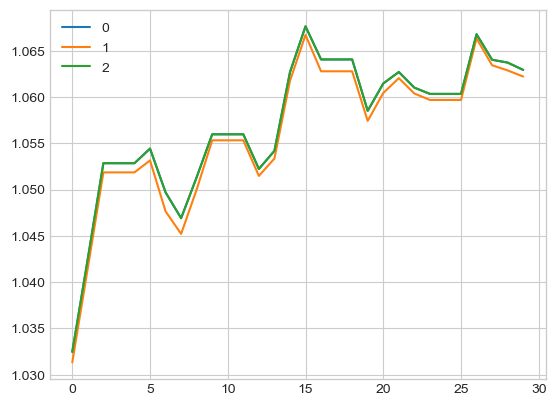

In [21]:
df.reset_index(drop=True).plot()

In [65]:
    # Récupération des données
    df_yf = yf.download('EURUSD=X', start='2017-12-21', end='2018-01-03')
    
df_yf

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-21,1.187775,1.189202,1.185017,1.187818,1.187818,0
2017-12-22,1.185157,1.186197,1.181754,1.185733,1.185733,0
2017-12-25,1.185677,1.188495,1.184904,1.185607,1.185607,0
2017-12-26,1.187127,1.187790,1.184750,1.187254,1.187254,0
2017-12-27,1.186099,1.191043,1.185565,1.185789,1.185789,0
2017-12-28,1.190023,1.195500,1.189825,1.190079,1.190079,0
2017-12-29,1.193987,1.202284,1.193802,1.194172,1.194172,0
2018-01-01,1.200495,1.201504,1.199904,1.200495,1.200495,0
2018-01-02,1.201086,1.208094,1.200855,1.201158,1.201158,0


### SGD REGRESSOR (SGD)

In [96]:
# First experiment with linear regression

# SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.
#search for the SGD-based linear regression with the optimal set of parameters. 
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 1e-05, 'eta0': 0.03, 'penalty': 'elasticnet'}
RMSE: 0.006
MAE: 0.005
R^2: 0.993


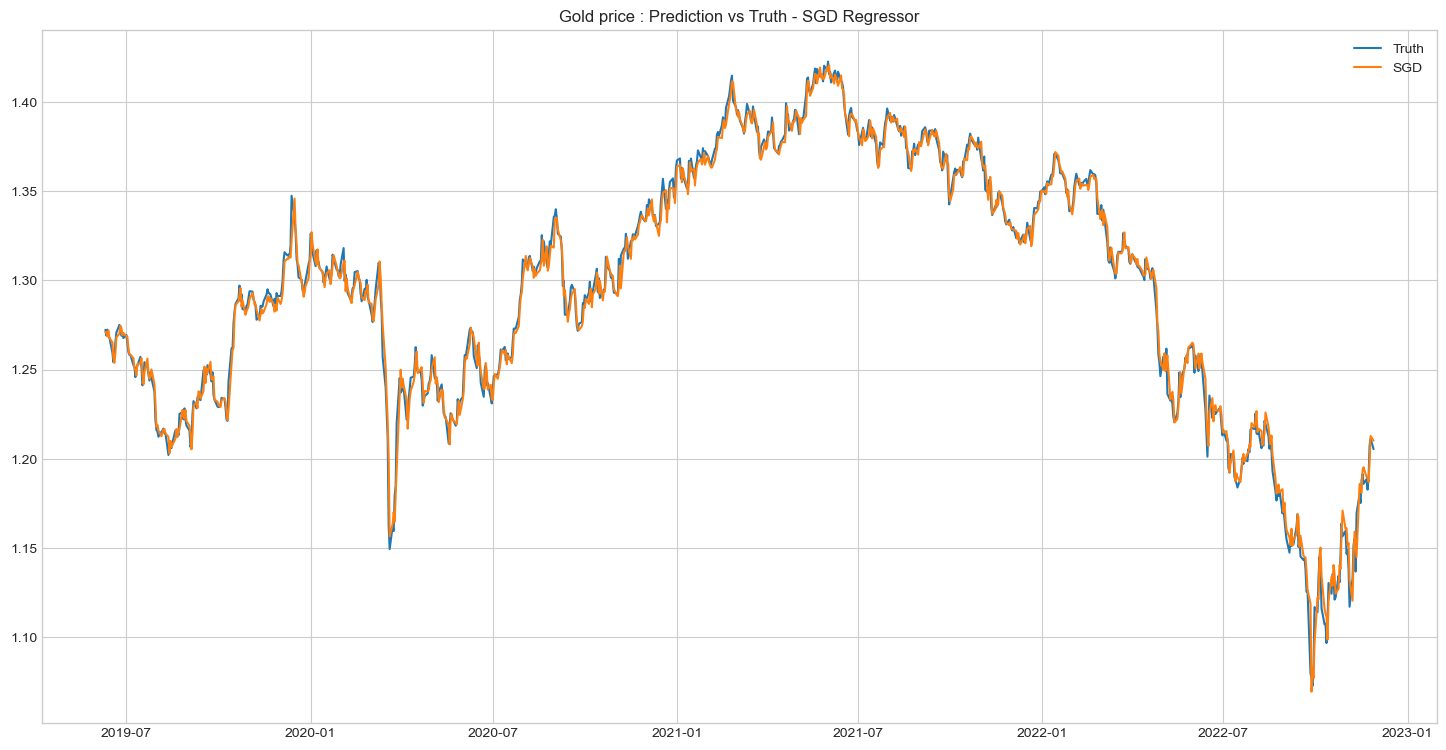

In [97]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('Gold price : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

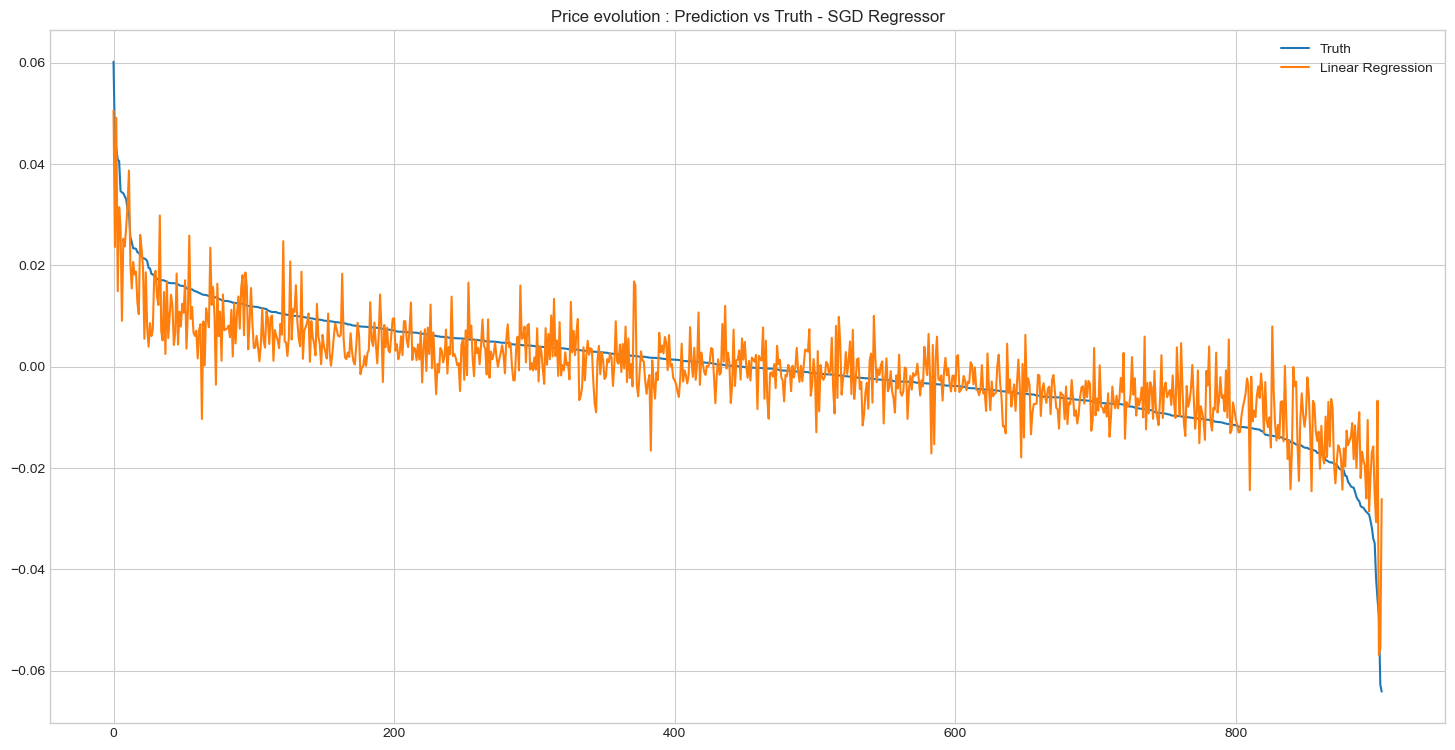

In [144]:
show_evolution(predictions_sgd, 'SGD Regressor')

### Extreme Gradient Boosting Regressor (XGB)

In [99]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 1, 'n_estimators': 300, 'subsample': 0.7}
RMSE: 0.012
MAE: 0.009
R^2: 0.974


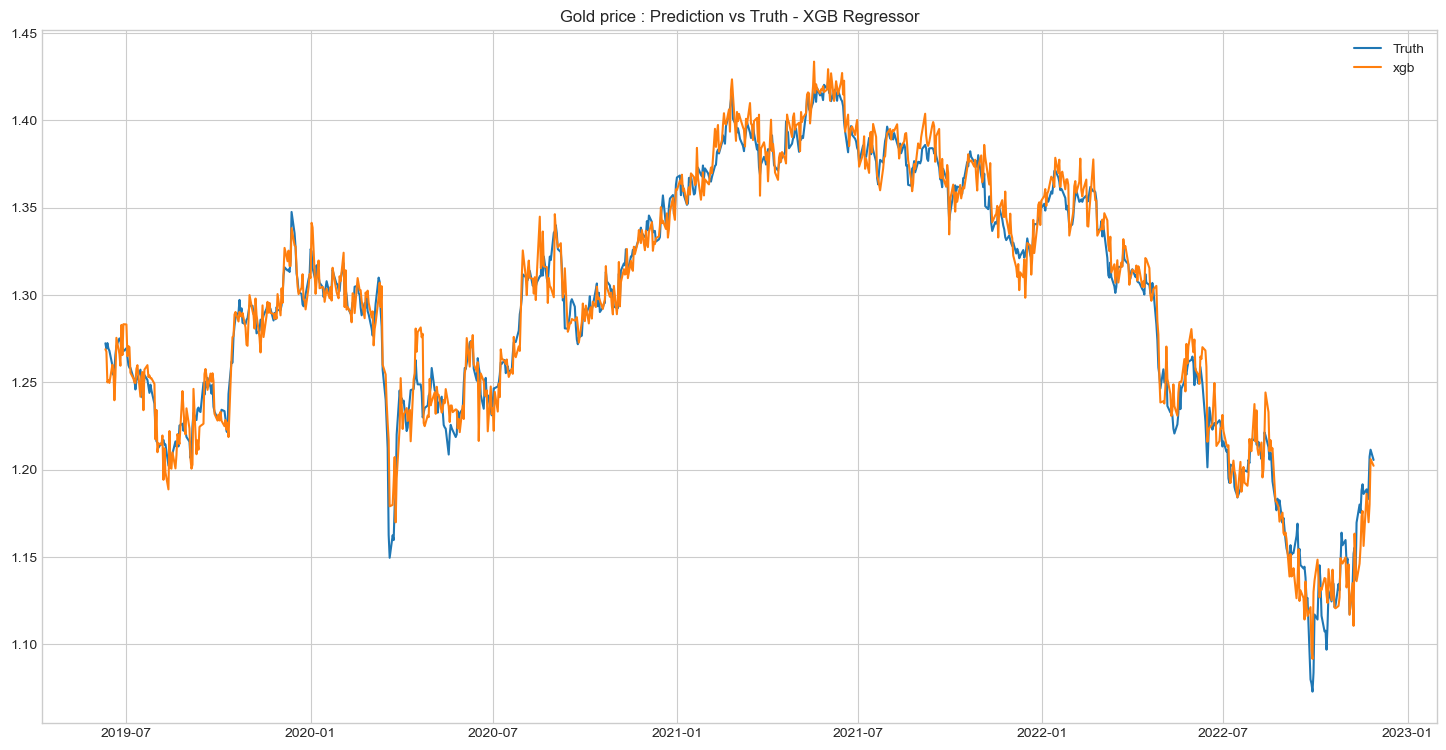

In [100]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('Gold price : Prediction vs Truth - XGB Regressor')
plt.show()

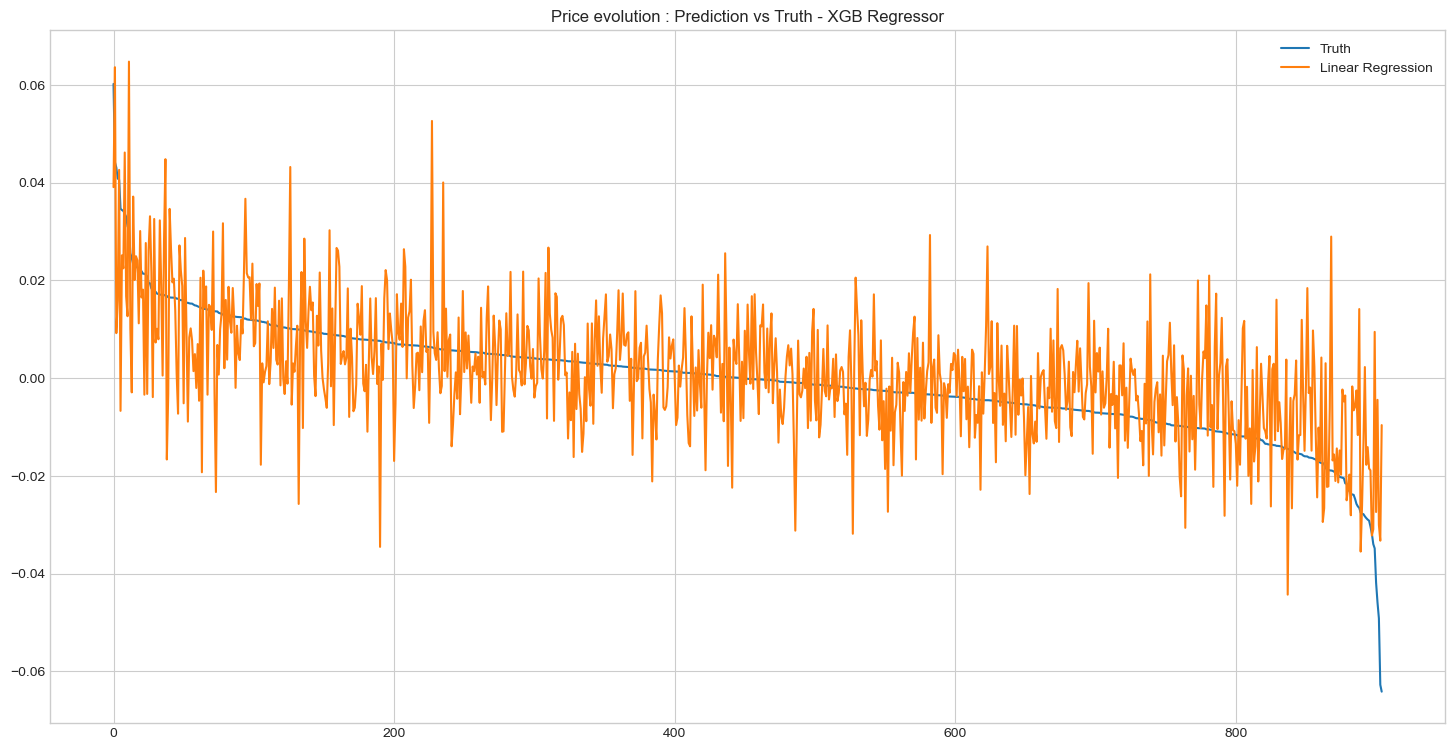

In [145]:
show_evolution(predictions_xgb, 'XGB Regressor')

### Bagging Regressor (BGR)

In [102]:
BaggingRegressor?

In [103]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 0.003
MAE: 0.002
R^2: 0.998


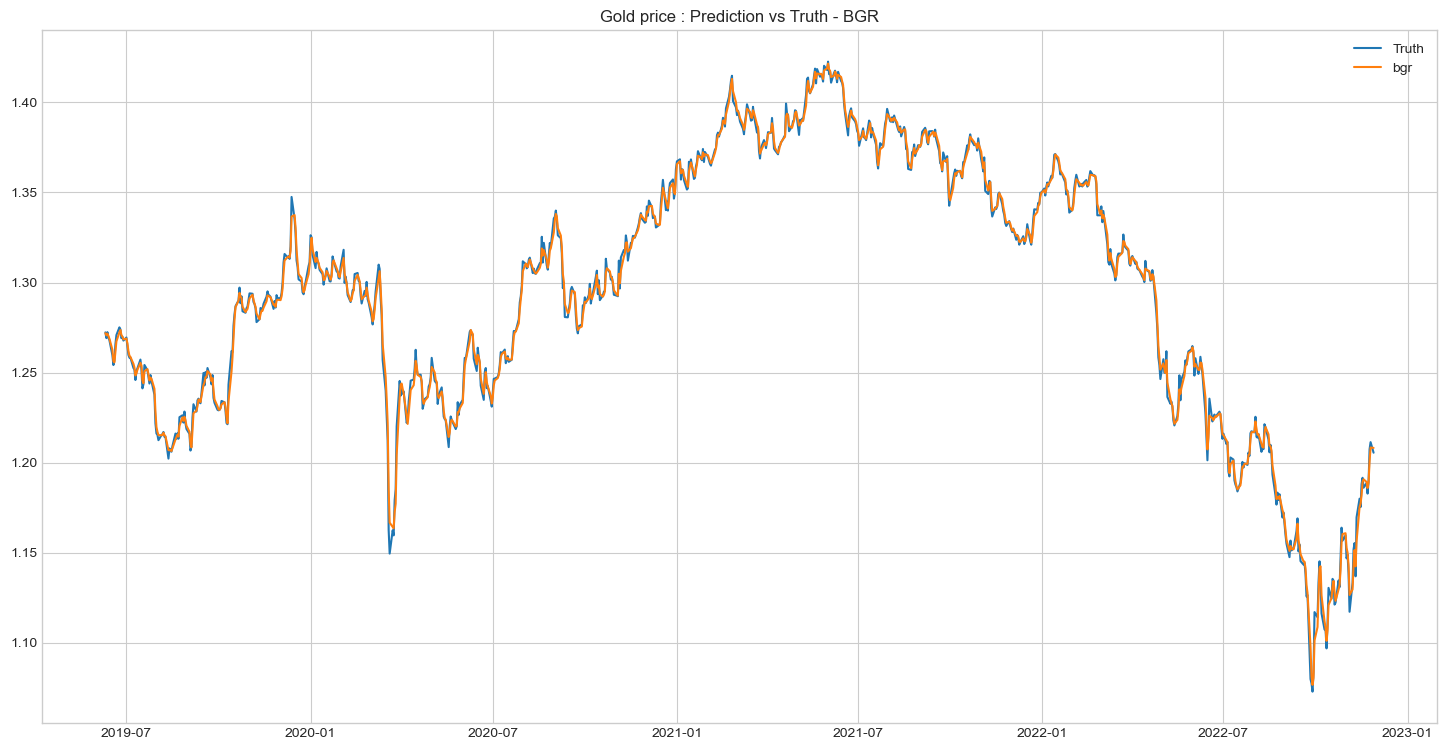

In [104]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('Gold price : Prediction vs Truth - BGR')
plt.show()

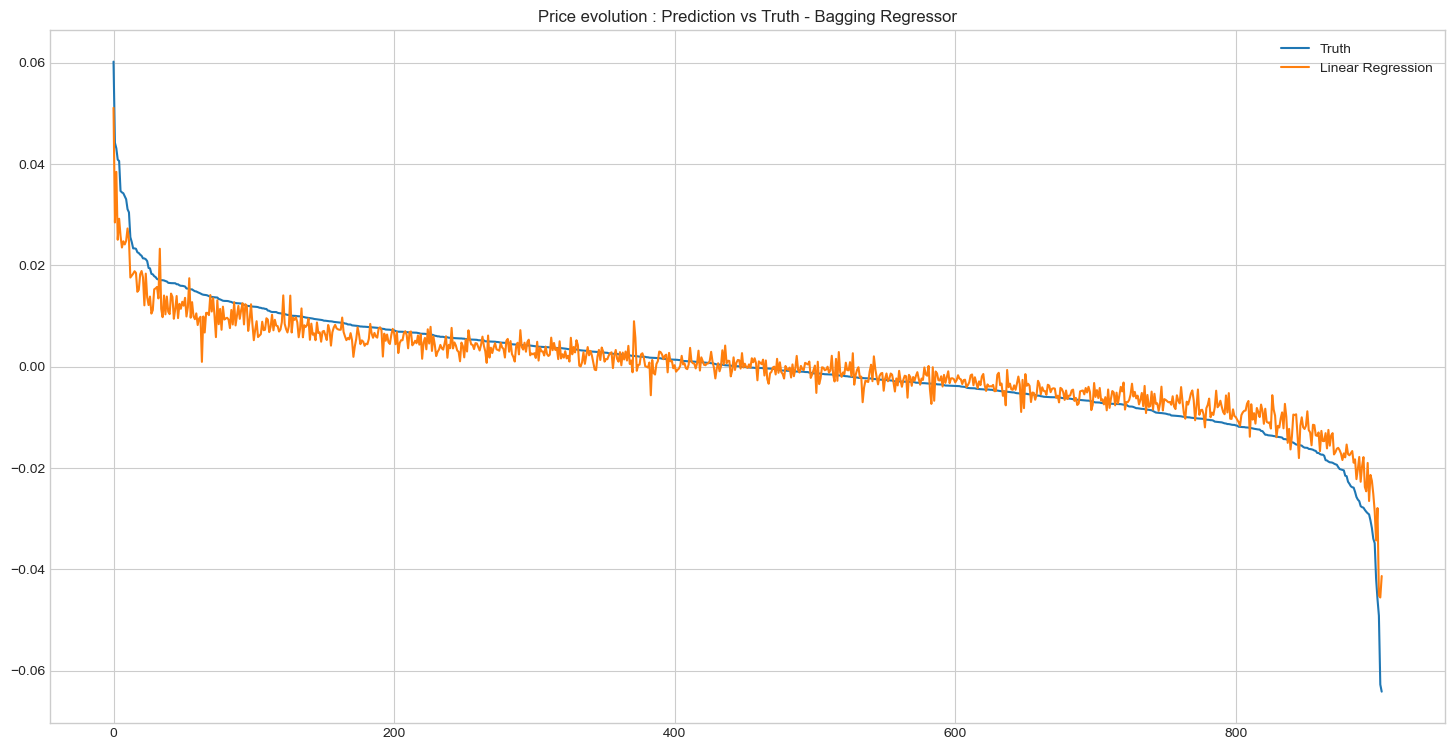

In [146]:
show_evolution(predictions_bgr, 'Bagging Regressor')

### Random Forest Regressor (RF)

In [106]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))


{'max_depth': 50, 'min_samples_split': 20}
RMSE: 0.004
MAE: 0.003
R^2: 0.997


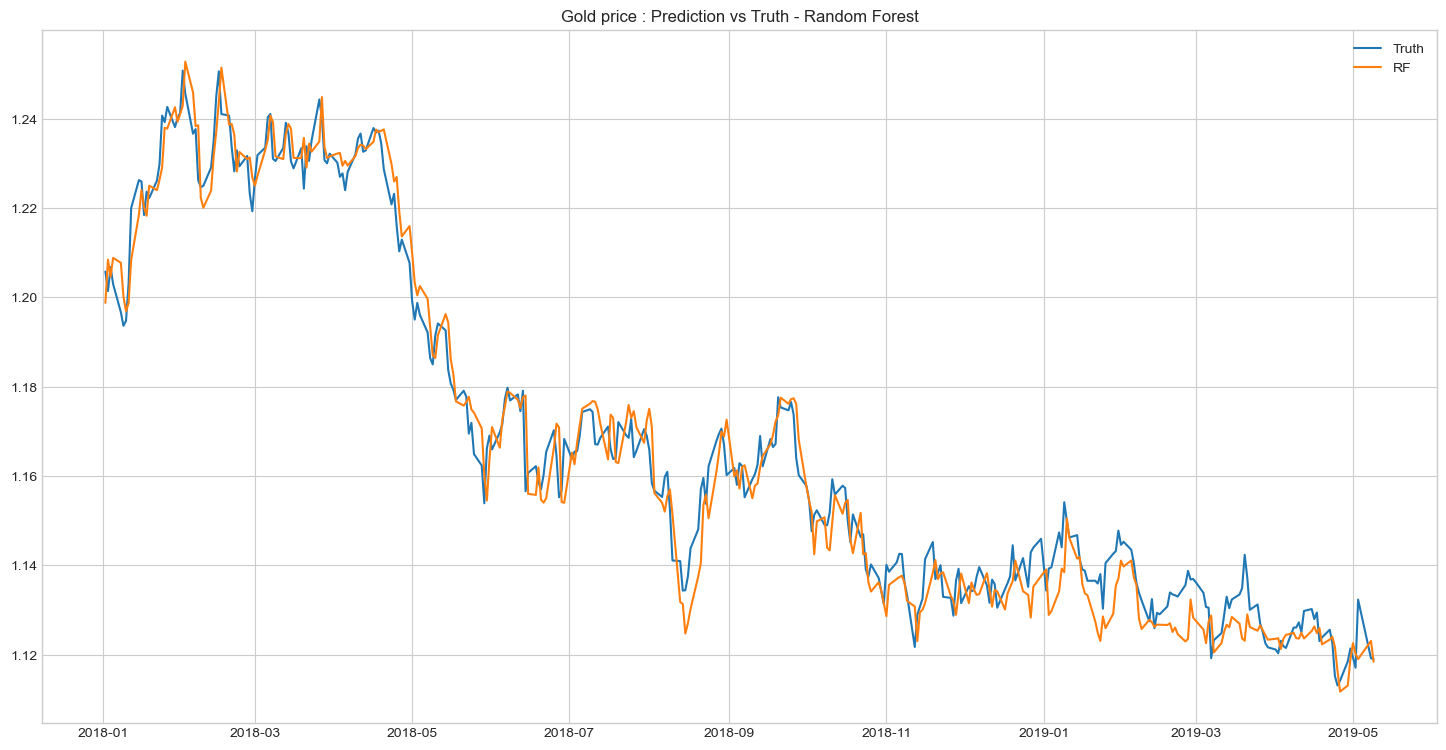

In [145]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('Gold price : Prediction vs Truth - Random Forest')
plt.show()

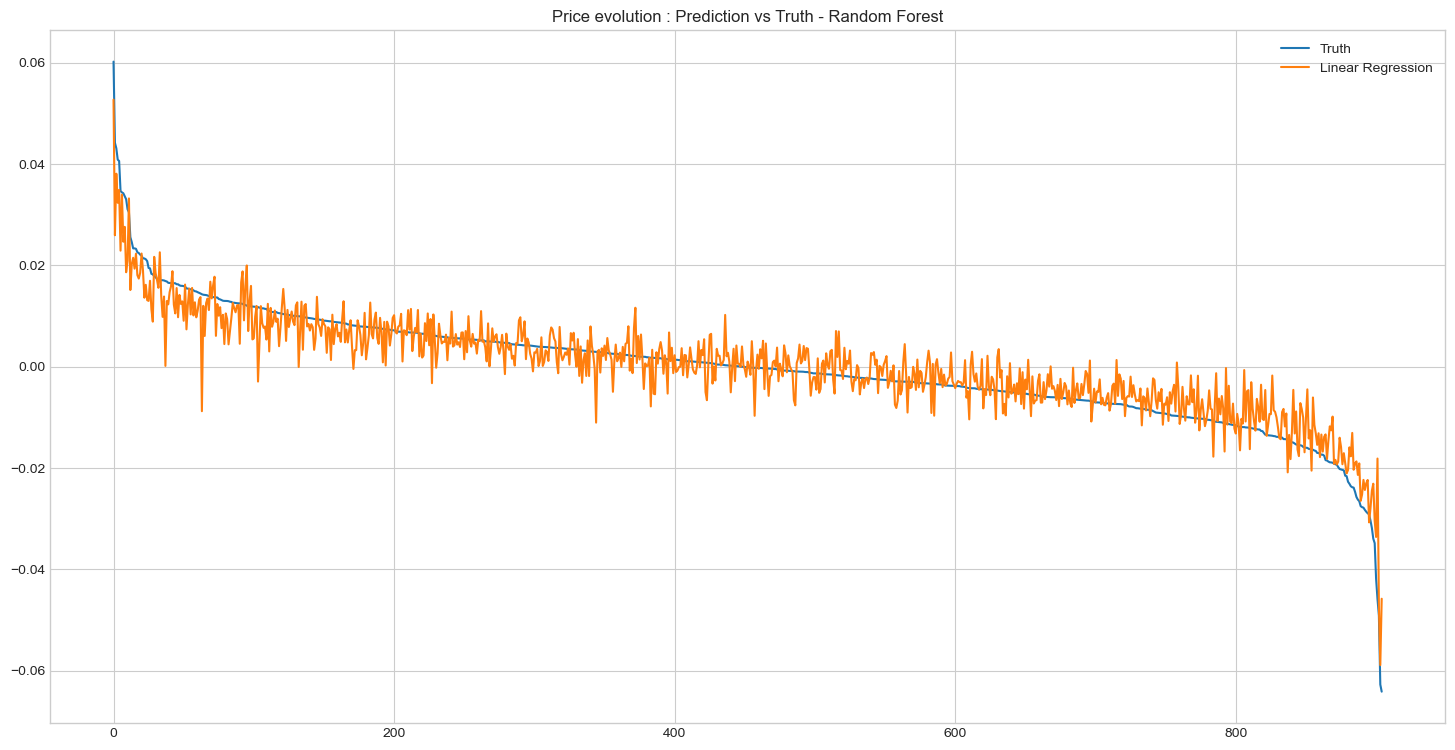

In [147]:
show_evolution(predictions_rf, 'Random Forest')

The model with the least mean_absolute_error:
 LIN    0.002326
dtype: float64


LIN    0.002326
SGD    0.004581
XGB    0.008843
BGR    0.002363
RFR    0.003100
dtype: float64

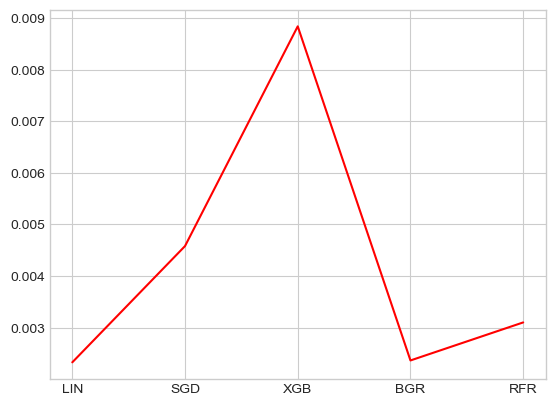

In [148]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                #'VTR':mean_absolute_error(y_test, predictions_vtr),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')
mae_scoring

### Saving, Loading and Predicting with the BGR Model

In [111]:
#saving the BGR model with sklearn:joblib
joblib.dump(bgr, 'bgr_eurusd_10062019.pkl')

['bgr_eurusd_10062019.pkl']

In [112]:
#loading the saved model
model = joblib.load('bgr_eurusd_10062019.pkl')

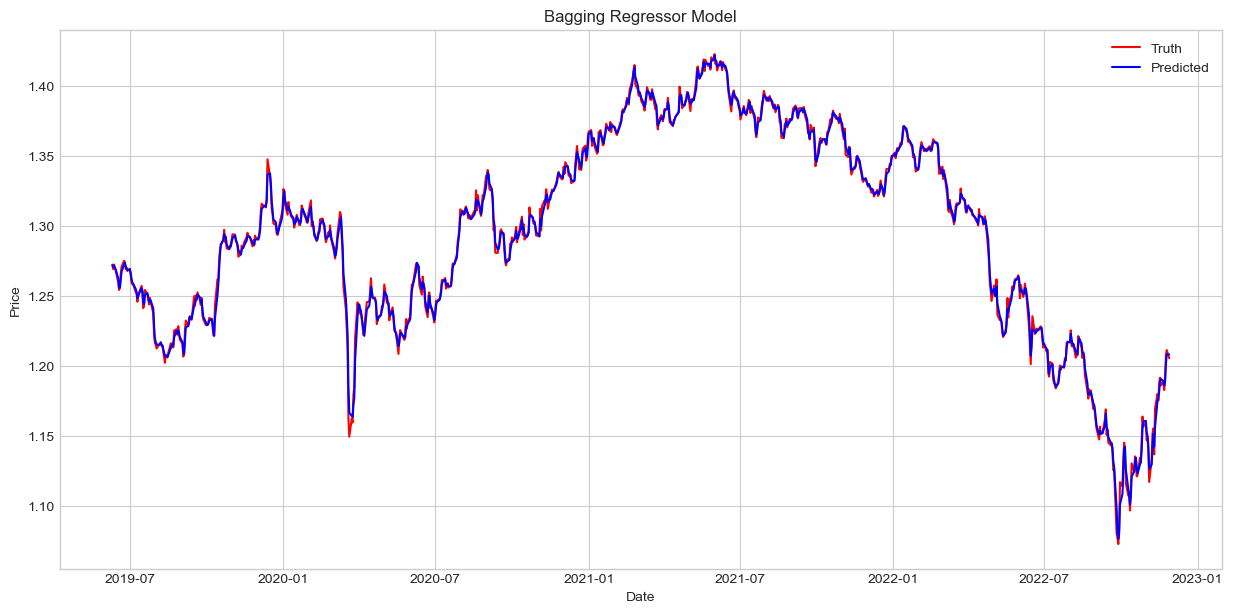

In [113]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

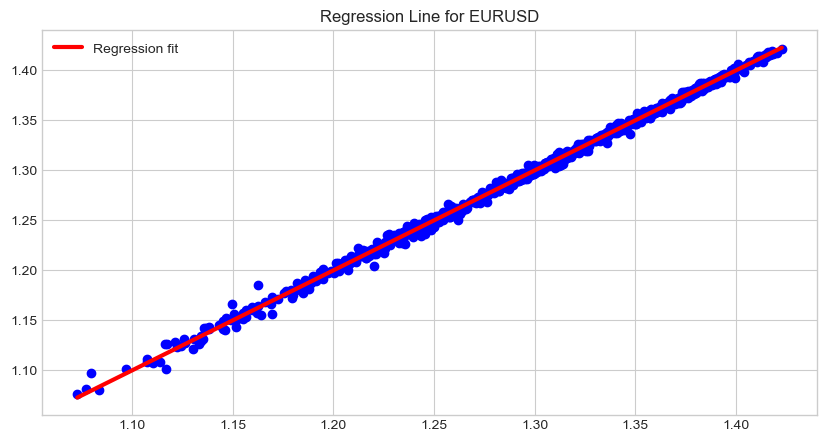

In [114]:
#plotting regression line
plt.style.use('seaborn-whitegrid')
plt.scatter(y_test, pred,color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=3, label='Regression fit')
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.title("Regression Line for EURUSD")
plt.legend()
plt.show()